In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

PREFIX='a video of '

In [4]:
events = [
    "Riding",
    "Fighting",
    "Playing",
    "Running",
    "Lying",
    "Chasing",
    "Jumping",
    "Falling",
    "Guiding",
    "Stealing",
    "Littering",
    "Tripping",
    "Pickpockering",
]
description = [
    "a person riding a bicycle",
    "a certain number of persons fighting",
    "a group of persons playing",
    "a person running",
    "a person lying in the floor",
    "a person chasing other person",
    "a person jumping",
    "a person falling",
    "a person guiding other person",
    "a person stealing other person",
    "a person throwing trash in the floor",
    "a person tripping",
    "a person stealing other person's pocket",
]
normal_prompt = "a normal view (persons walking or standing)"
description.append(normal_prompt)
description=[PREFIX +desc for desc in description]
events_description = {event: desc for event, desc in zip(events, description)}

In [5]:
def check_precision(frames_number, video_name, predicted_events, event, anomaly_classes, prompts, mode):
    # TN Prediction and Reality are true
    # TN Prediction and Reality are false
    # FN Prediction is false and Reality is true
    # FP Prediction is true and Reality is false
    normal_class = PREFIX + "a normal view (persons walking or standing)"
    all_classes = anomaly_classes
    frames = np.load("/home/ubuntu/Database/ALL/GT/gt_ALL.npz")
    frames= frames[video_name]
    frames = np.append(frames, frames[-1])
    # Create a dictionary to convert class names to numeric indices
    class_to_idx = {cls: idx for idx, cls in enumerate(all_classes)}
    # Example: {"a normal view...": 0, "a person riding...": 1, ...}
    num_classes = len(all_classes)  # 14
    cm = np.zeros((num_classes, num_classes), dtype=int)
    #prompts = [prompt.lower().split('.')[0] for prompt in prompts]
    # Save frames_number, predicted_events, and prompts into a numpy array)
    for i in range(len(predicted_events)):
        is_anomaly = frames[frames_number[i] - 1]  # 0 or 1
        # Determine true class using EVENT when anomaly exists
        true_class = event if is_anomaly == 1 else normal_class
        #pred_class = predicted_events[i]
        status=False
        for j in range(len(all_classes)):
            if all_classes[j] in predicted_events[i]:
                pred_class=all_classes[j]
                status=True
                break
        # Get ground truth
        if status:
            pass
        else:
            continue
        # Convert to indices (skip if class not recognized)
        true_idx = class_to_idx.get(true_class, -1)
        pred_idx = class_to_idx.get(pred_class, -1)
        
        if true_idx != -1 and pred_idx != -1:
            cm[true_idx, pred_idx] += 1
    # Get the index of your event class
    event_idx = class_to_idx[event]
    

    # Calculate metrics ONLY for your event class
    tp = cm[event_idx, event_idx]  # TNs for event
    fp = np.sum(cm[:, event_idx]) - tp  # FPs (other classes predicted as event)
    fn =  np.sum(cm[event_idx, :]) - tp  # FNs (event misclassified as others)
    tn = np.sum(cm) - tp - fp - fn  # TNs
    return tp, fp, fn, tn, cm

rute="/home/ubuntu/Database/ALL/Videos"
rute_stored='/home/ubuntu/Tesis/Storage/M4Multiclass/'
modes=[3]
usage='CLIP'
all_prompts = []
df= pd.DataFrame(columns=['Name', 'Event', 'Mode', 'TP', 'FP', 'FN', 'TN'])
prompts_number=0
class_to_idx = {cls: idx for idx, cls in enumerate(description)}
# Example: {"a normal view...": 0, "a person riding...": 1, ...}
num_classes = len(description)  # 14
cm_sum = np.zeros((num_classes, num_classes), dtype=int)
for mode in modes:
    for folder_number in range(len(events)):
        folder=f"{rute}/{events[folder_number]}/"
        files= os.listdir(folder)
        for file in files:
            stored_file=file.split('.')[0]
            desc=events_description[events[folder_number]]
            try:
                info_stored=np.load(f"{rute_stored}{stored_file}_{usage}_{mode}_{desc}.npy", allow_pickle=True)
                frames_number=info_stored[0]
                predicted_events=info_stored[1]
                #print(predicted_events)
                prompts=info_stored[2]
                all_prompts += list(prompts)
                prompts_number += len(prompts)
                event= events_description[events[folder_number]]
                #print(f'{file} {event} {prompts}\n')
                tp, fp,fn, tn, cm=check_precision(frames_number, stored_file, predicted_events, event, description, prompts, mode)
                cm_sum += cm
                row = {
                'Name':stored_file, 'Event':event, 'Mode':mode, 'TP':tp, 'FP':fp, 'FN':fn, 'TN':tn
                }
                df =pd.concat([df, pd.DataFrame([row])], ignore_index=True)            
            except:
                pass
print(df)
print(prompts_number)

        Name                                              Event Mode  TP FP  \
0     000350               a video of a person riding a bicycle    3   0  0   
1     000289               a video of a person riding a bicycle    3  11  0   
2    4_076_1               a video of a person riding a bicycle    3   8  0   
3     000326               a video of a person riding a bicycle    3   0  0   
4     000313               a video of a person riding a bicycle    3   0  0   
..       ...                                                ...  ...  .. ..   
247  1_075_1  a video of a person stealing other person's po...    3   0  0   
248  4_086_1  a video of a person stealing other person's po...    3   0  0   
249  D158_13  a video of a person stealing other person's po...    3   0  0   
250  D149_07  a video of a person stealing other person's po...    3   0  0   
251  D149_03  a video of a person stealing other person's po...    3   0  0   

     FN   TN  
0    88   46  
1    85  134  
2    3

In [6]:
correct=0
for answer in all_prompts:
    for i in range(len(description)):
        if description[i] in answer:
            correct += 1
print(f"Total correct prompts: {correct} out of {prompts_number} ({correct/prompts_number*100:.2f}%)")

Total correct prompts: 39431 out of 41681 (94.60%)


In [7]:
true_positives=df.loc[df['TP'] > 0]
print(f"Total true positives: {len(true_positives)} out of {len(df)} ({len(true_positives)/len(df)*100:.2f}%)")
print(true_positives.shape, df.shape)
no_true_positives=df.loc[df['TP'] ==0]
print(no_true_positives)

Total true positives: 122 out of 252 (48.41%)
(122, 7) (252, 7)
        Name                                              Event Mode TP FP  \
0     000350               a video of a person riding a bicycle    3  0  0   
3     000326               a video of a person riding a bicycle    3  0  0   
4     000313               a video of a person riding a bicycle    3  0  0   
5     000325               a video of a person riding a bicycle    3  0  0   
6     000345               a video of a person riding a bicycle    3  0  0   
..       ...                                                ...  ... .. ..   
247  1_075_1  a video of a person stealing other person's po...    3  0  0   
248  4_086_1  a video of a person stealing other person's po...    3  0  0   
249  D158_13  a video of a person stealing other person's po...    3  0  0   
250  D149_07  a video of a person stealing other person's po...    3  0  0   
251  D149_03  a video of a person stealing other person's po...    3  0  0   


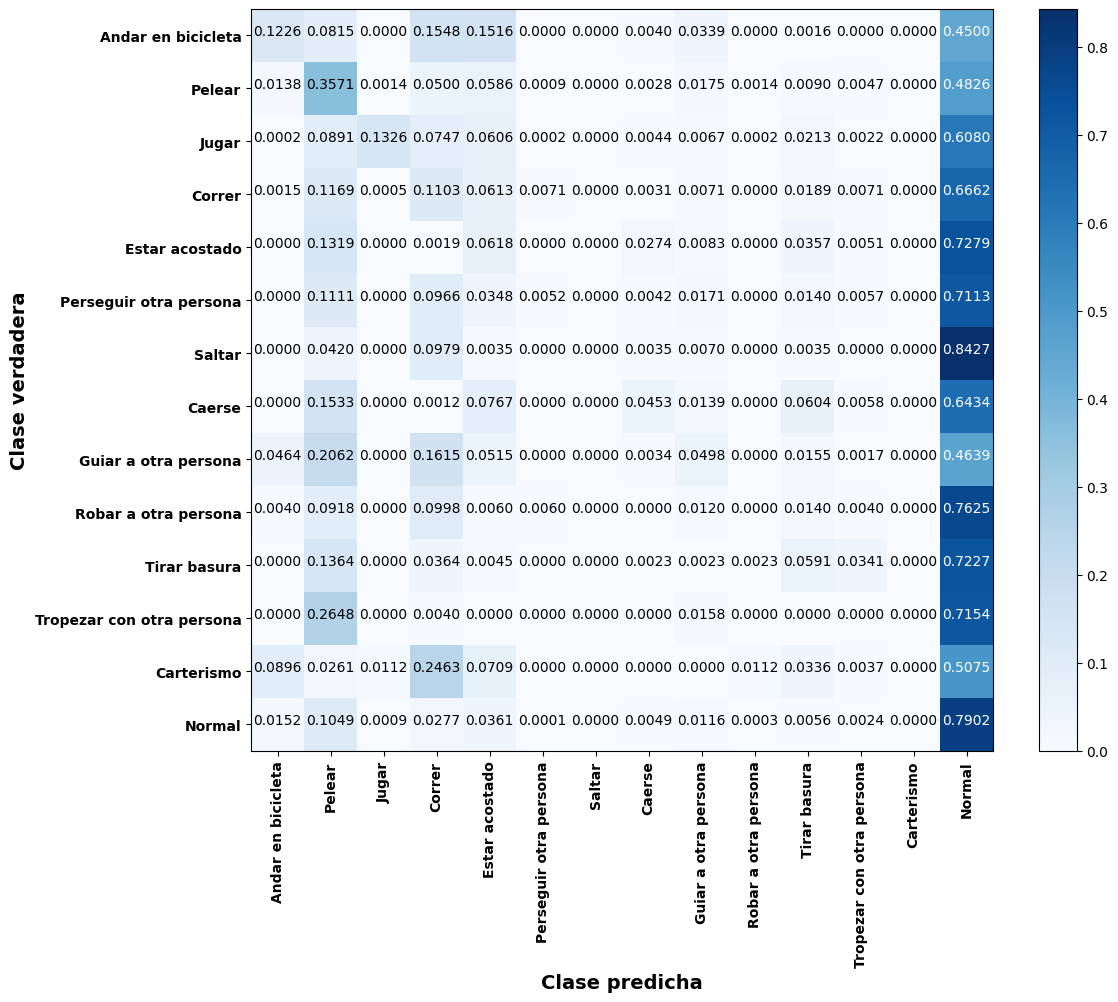

In [8]:
plt.figure(figsize=(12, 10))
cm_sum = cm_sum / cm_sum.sum(axis=1, keepdims=True)
plt.imshow(cm_sum, interpolation='nearest', cmap=plt.cm.Blues)
#plt.title(f"Matriz de confusión: {mode_names[mode]}", fontsize=16, fontweight='bold')
plt.xlabel("Clase predicha", fontsize=14, fontweight='bold')
plt.ylabel("Clase verdadera", fontsize=14, fontweight='bold')
plt.colorbar()
# Replace class names with the ones from the replace list
replace = [
    "Andar en bicicleta",
    "Pelear",
    "Jugar",
    "Correr",
    'Estar acostado',
    "Perseguir otra persona",
    "Saltar",
    "Caerse",
    "Guiar a otra persona",
    "Robar a otra persona",
    "Tirar basura",
    "Tropezar con otra persona",
    "Carterismo",
    'Normal',
]
updated_classes = replace
tick_marks = np.arange(num_classes)   
plt.xticks(tick_marks, updated_classes, rotation=90, fontweight='bold')  # Rotate x-axis labels for better visibility
plt.yticks(tick_marks, updated_classes, fontweight='bold')   # Annotate the matrix with the values
thresh = cm_sum.max() / 2.0
for i, j in np.ndindex(cm_sum.shape):
    plt.text(j, i, f"{cm_sum[i, j]:.4f}",
                        horizontalalignment="center",
                        color="white" if cm_sum[i, j] > thresh else "black")   
plt.tight_layout()
#plt.savefig(f"CM/confusion_matrix_{mode_names[mode]}.png", bbox_inches='tight')
plt.show()

In [9]:
df_respaldo=df.copy()
#df_respaldo=df_respaldo.loc[~df_respaldo["Name"].str.endswith("_1")] 
print(df_respaldo)
df_sum = df_respaldo.groupby(["Event", "Mode"])[
    ["TP", "FP", "FN", "TN"]
].sum().reset_index()

# Initialize precision, recall, accuracy with zeros
df_sum["Precision"] = 0.0
df_sum["Recall"] = 0.0
df_sum["Accuracy"] = 0.0

# Calculate only where the denominator is not zero
mask_prec = (df_sum["TP"] + df_sum["FP"]) != 0
df_sum.loc[mask_prec, "Precision"] = (
    df_sum.loc[mask_prec, "TP"] / (df_sum.loc[mask_prec, "TP"] + df_sum.loc[mask_prec, "FP"])
)

mask_recall = (df_sum["TP"] + df_sum["FN"]) != 0
df_sum.loc[mask_recall, "Recall"] = (
    df_sum.loc[mask_recall, "TP"] / (df_sum.loc[mask_recall, "TP"] + df_sum.loc[mask_recall, "FN"])
)

mask_acc = (df_sum["TP"] + df_sum["FP"] + df_sum["FN"] + df_sum["TN"]) != 0
df_sum.loc[mask_acc, "Accuracy"] = (
    (df_sum.loc[mask_acc, "TP"] + df_sum.loc[mask_acc, "TN"]) /
    (df_sum.loc[mask_acc, "TP"] + df_sum.loc[mask_acc, "FP"] + df_sum.loc[mask_acc, "FN"] + df_sum.loc[mask_acc, "TN"])
)
df_sum.drop(columns=['TP', 'FP', 'FN', 'TN'], inplace=True)
df_sum['F1'] = 2 * df_sum['Precision'].astype(float) * df_sum['Recall'].astype(float) / (df_sum['Precision'].astype(float) + df_sum['Recall'].astype(float))
df_sum['F1'].fillna(0, inplace=True)  # Handle division by zero
df_sum.drop(columns=['Event'], inplace=True)
df_sum=df_sum.groupby(["Mode"]).mean()
mode_names = {
        0: "CLIP y Reglas",
        1: "CLIP y Reglas con MLLM",
        2: "CLIP y Reglas Una clase",
    }
df_sum.rename(index=mode_names, inplace=True)
print(df_sum)

        Name                                              Event Mode  TP FP  \
0     000350               a video of a person riding a bicycle    3   0  0   
1     000289               a video of a person riding a bicycle    3  11  0   
2    4_076_1               a video of a person riding a bicycle    3   8  0   
3     000326               a video of a person riding a bicycle    3   0  0   
4     000313               a video of a person riding a bicycle    3   0  0   
..       ...                                                ...  ...  .. ..   
247  1_075_1  a video of a person stealing other person's po...    3   0  0   
248  4_086_1  a video of a person stealing other person's po...    3   0  0   
249  D158_13  a video of a person stealing other person's po...    3   0  0   
250  D149_07  a video of a person stealing other person's po...    3   0  0   
251  D149_03  a video of a person stealing other person's po...    3   0  0   

     FN   TN  
0    88   46  
1    85  134  
2    3

/tmp/ipykernel_33646/2034563803.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.7934668071654373 0.9825986078886311 1.0 0.9285714285714286
 0.8787878787878788 0.97 1.0 0.8816326530612245 0.6666666666666666]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_sum.loc[mask_prec, "Precision"] = (
/tmp/ipykernel_33646/2034563803.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.3571259188996917 0.132592360676268 0.005192107995846314
 0.04529616724738676 0.04982817869415808 0.0 0.061822817080943275
 0.12258064516129032 0.11026033690658499 0.0 0.0 0.05909090909090909 0.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_sum.loc[mask_recall, "Recall"] = (
/tmp/ipykernel_33646/2034563803.py:25: FutureWarning: Setting an item of i

In [10]:
def calculate_ap(precision, recall):
    # Sort by recall (ascending)
    sorted_indices = np.argsort(recall)
    precision = np.array(precision)[sorted_indices]
    recall = np.array(recall)[sorted_indices]

    # Pad with (0,0) and (1,0)
    precision = np.concatenate(([0], precision, [0]))
    recall = np.concatenate(([0], recall, [1]))

    # Compute AP as the area under the raw curve (no interpolation)
    ap = 0.0
    for i in range(1, len(recall)):
        delta_recall = recall[i] - recall[i - 1]
        ap += delta_recall * precision[i]

    return ap
df_check = df_respaldo.copy()

# Initialize precision, recall, accuracy with zeros
df_check["Precision"] = 0.0
df_check["Recall"] = 0.0
df_check["Accuracy"] = 0.0

# Calculate only where the denominator is not zero
mask_prec = (df_check["TP"] + df_check["FP"]) != 0
df_check.loc[mask_prec, "Precision"] = (
    df_check.loc[mask_prec, "TP"] / (df_check.loc[mask_prec, "TP"] + df_check.loc[mask_prec, "FP"])
)

mask_recall = (df_check["TP"] + df_check["FN"]) != 0
df_check.loc[mask_recall, "Recall"] = (
    df_check.loc[mask_recall, "TP"] / (df_check.loc[mask_recall, "TP"] + df_check.loc[mask_recall, "FN"])
)

mask_acc = (df_check["TP"] + df_check["FP"] + df_check["FN"] + df_check["TN"]) != 0
df_check.loc[mask_acc, "Accuracy"] = (
    (df_check.loc[mask_acc, "TP"] + df_check.loc[mask_acc, "TN"]) /
    (df_check.loc[mask_acc, "TP"] + df_check.loc[mask_acc, "FP"] + df_check.loc[mask_acc, "FN"] + df_check.loc[mask_acc, "TN"])
)
df_check['F1'] = 2 * df_check['Precision'].astype(float) * df_check['Recall'].astype(float) / (df_check['Precision'].astype(float) + df_check['Recall'].astype(float))
df_check['F1'].fillna(0, inplace=True)  # Handle division by zero
categories = df_check["Event"].unique()
# Separate rows by category
df_check.fillna(0, inplace=True)
category_dfs = {category: df_check[df_check["Event"] == category] for category in categories}

mAP_process = []
for i in range(len(categories)):
    df1 = category_dfs[categories[i]]
    #
    grouped = df1.groupby("Mode")
    # ----------------------------------------------------------------------
    # Ejecución del código
    ap_values = {}
    for mode, group in grouped:
        precision = np.array(group["Precision"].values)
        recall = np.array(group["Recall"].values)
        #print("Mode:", mode, "\n")
        #print("Precision:", precision, "Recall:", recall)
        # Comenta la siguiente línea para verificar si el error es aquí
        ap = calculate_ap(precision, recall)
        ap_values[mode] = ap
        #print(f'{mode} {categories[i]} AP: {ap:.4f}')
    mean_values = grouped[["Precision", "Recall",  "F1"]].mean()
    mean_values["AP"] = [ap_values[mode] for mode in mean_values.index]
    mean_values = mean_values[["AP"]]
    mAP_process.append(mean_values)
    # Plot the results
    mode_names = {
        0: "CLIP y Reglas",
        1: "CLIP y Reglas con MLLM",
        2: "CLIP y Reglas Una clase",
    }
    mean_values.rename(index=mode_names, inplace=True)
    # plt.xlim(0.4)
# Calculate the mean Average Precision (mAP) for each mode
mAP_values = pd.concat(mAP_process).groupby(level=0).mean()
print(mAP_values)


            AP
Mode          
3     0.265011


/tmp/ipykernel_33646/35596554.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.25 1.0
 0.8571428571428571 0.8493150684931506 0.9655172413793104 1.0 1.0
 0.5084745762711864 0.7884615384615384 0.9032258064516129
 0.9753086419753086 0.7579617834394905 1.0 0.7884615384615384 0.609375 1.0
 1.0 0.9454545454545454 0.9122807017543859 0.5 0.9523809523809523
 0.7571428571428571 1.0 0.8 1.0 1.0 1.0 1.0 0.7321428571428571 0.6
 0.4146341463414634 0.17391304347826086 0.0 1.0 0.7894736842105263
 0.46153846153846156 0.8412698412698413 1.0 0.5932203389830508
 0.42857142857142855 1.0 0.8148148148148148 1.0 1.0 1.0 1.0 1.0 1.0 0.5
 0.8548387096774194 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 0.6666666666666666 1.0 1.0 0.0 0.0 0.8571428571428571 1.0 0.9375 0.0 1.0
 0.0 0.8 0.0 1.0 1.0 0.3333333333333333 1.0 0.8181818181818182 1.0 1.0 1.0
 1.0 1.0 1.0 1.0 1.0 0.4 1.0 0.75

In [11]:
df_fps= pd.read_csv("/home/ubuntu/Tesis/Results/TestingDevM4MC.csv")
print(df_fps["Process time"].sum()/(60*60), "hours\n\n")
df_fps["Process time"] = df_fps["Process time"] / df_fps["Duration"]
df_fps.loc[df_fps["Name"].str.contains("_1.mp4"), "Process time"] = (
        30.0 / df_fps["Process time"]
    )
df_fps.loc[~df_fps["Name"].str.contains("_1.mp4"), "Process time"] = (
        25.0 / df_fps["Process time"]
    )
print(df_fps)
categories = df_fps["True Event"].unique()
category_dfs = {category: df_fps[df_fps["True Event"] == category] for category in categories}
print(categories)
mAP_process = []
for i in range(len(categories)):
    df1 = category_dfs[categories[i]]
    grouped = df1.groupby("Mode")
    mean_values = grouped[["Process time"]].mean()
    mean_values = mean_values[["Process time"]]
    mAP_process.append(mean_values)
# Calculate the mean Average Precision (mAP) for each mode
mAP_values = pd.concat(mAP_process).groupby(level=0).mean()
print("\n\n", mAP_values)

14.333069005476103 hours


            Name  Mode  True Positive  False Positive  False Negative  \
0    1_066_1.mp4     3              0               0               0   
1     000253.avi     3              0               0               0   
2    D235_01.avi     3              0               0               0   
3    D013_02.avi     3              0               0               0   
4     000324.avi     3              0               0               0   
..           ...   ...            ...             ...             ...   
247  3_095_1.mp4     3              0               0               0   
248  3_084_1.mp4     3              0               0               0   
249  1_086_1.mp4     3              0               0               0   
250  D149_07.avi     3              0               0               0   
251  D149_03.avi     3              0               0               0   

     True Negative                                         True Event  \
0                0     